In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import random

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [22]:
# same as sklearn 
df = pd.read_csv("data/allHorizonData_cut.csv")

features = ['gameLength', 'uc', 'r1', 'r2', 'r3', 'r4', 'c1', 'c2', 'c3', 'c4', 'rt1', 'rt2', 'rt3', 'rt4']
target = 'c5'

X = df[features]
y = df[target]
y = y-1 # binary CE only takes in 0, 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split based on original data frame
h1_mask = X_test['gameLength'] == 5
h6_mask = X_test['gameLength'] == 10

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("--- Feature Data (X) ---")
print(X.head())
print("\n--- Target Data (y) ---")
print(y.head())

--- Feature Data (X) ---
   gameLength  uc  r1  r2  r3  r4  c1  c2  c3  c4       rt1       rt2  \
0           5   3  66  80  29  75   2   2   1   2  1.849054  1.771619   
1          10   3  69  50  51  64   2   2   1   2  0.967068  0.495166   
2          10   2  31  43  26  36   2   1   2   1  0.862793  0.490816   
3          10   2  65  77  52  73   1   2   2   1  6.272626  1.204784   
4          10   2  70  19  43  41   2   1   2   1  0.614185  0.364167   

        rt3       rt4  
0  0.562676  0.578808  
1  0.506639  0.460037  
2  0.924838  0.951034  
3  0.795462  0.457327  
4  0.306713  0.372321  

--- Target Data (y) ---
0    1
1    0
2    0
3    0
4    1
Name: c5, dtype: int64


convert to tensor for pytorch

In [4]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [5]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_test_tensor = torch.tensor(X_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [6]:
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [25]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
h1_mask_bool = torch.tensor(h1_mask, dtype=torch.bool)
h6_mask_bool = torch.tensor(h6_mask, dtype=torch.bool)

X_test_h1 = X_test_tensor[h1_mask_bool]
X_test_h6 = X_test_tensor[h6_mask_bool]

y_test_h1 = y_test_tensor[h1_mask_bool]
y_test_h6 = y_test_tensor[h6_mask_bool]

test_loader_h1 = DataLoader(TensorDataset(X_test_h1, y_test_h1), batch_size=32, shuffle=False)
test_loader_h6 = DataLoader(TensorDataset(X_test_h6, y_test_h6), batch_size=32, shuffle=False)

# Model

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, output_size)

        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# train / eval

In [10]:
def train(model, train_loader, criterion, optimizer, device, epoch): 
    model.train()
    train_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return avg_loss


def test(model, test_loader, device):
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs)
            preds = preds.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(test_loader.dataset)
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

# running experiment

In [8]:
num_features = len(features)
num_classes = 2

model = MLP(num_features, num_classes).to(device)
print(model)

MLP(
  (fc1): Linear(in_features=14, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 20
loss_prog = []
acc_prog = []

for epoch in range(epochs):
    loss = train(model, train_loader, criterion, optimizer, device, epoch)
    acc = test(model, test_loader, device)
    loss_prog.append(loss)
    acc_prog.append(acc)

Epoch 1, Loss: 0.6041
Test Accuracy: 0.7794
Epoch 2, Loss: 0.4971
Test Accuracy: 0.7867
Epoch 3, Loss: 0.4835
Test Accuracy: 0.7961
Epoch 4, Loss: 0.4774
Test Accuracy: 0.7956
Epoch 5, Loss: 0.4738
Test Accuracy: 0.7935
Epoch 6, Loss: 0.4715
Test Accuracy: 0.7937
Epoch 7, Loss: 0.4690
Test Accuracy: 0.7964
Epoch 8, Loss: 0.4668
Test Accuracy: 0.7958
Epoch 9, Loss: 0.4660
Test Accuracy: 0.7979
Epoch 10, Loss: 0.4640
Test Accuracy: 0.7974
Epoch 11, Loss: 0.4641
Test Accuracy: 0.7961
Epoch 12, Loss: 0.4611
Test Accuracy: 0.7974
Epoch 13, Loss: 0.4603
Test Accuracy: 0.7958
Epoch 14, Loss: 0.4584
Test Accuracy: 0.7953
Epoch 15, Loss: 0.4575
Test Accuracy: 0.7961
Epoch 16, Loss: 0.4572
Test Accuracy: 0.8021
Epoch 17, Loss: 0.4572
Test Accuracy: 0.7951
Epoch 18, Loss: 0.4564
Test Accuracy: 0.8013
Epoch 19, Loss: 0.4551
Test Accuracy: 0.7979
Epoch 20, Loss: 0.4546
Test Accuracy: 0.8021


In [12]:
import matplotlib.pyplot as plt

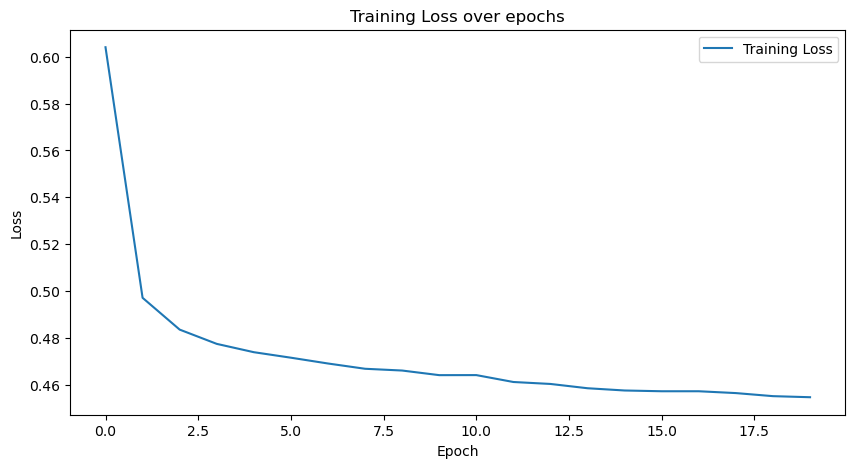

In [14]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss_prog, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend()
plt.show()

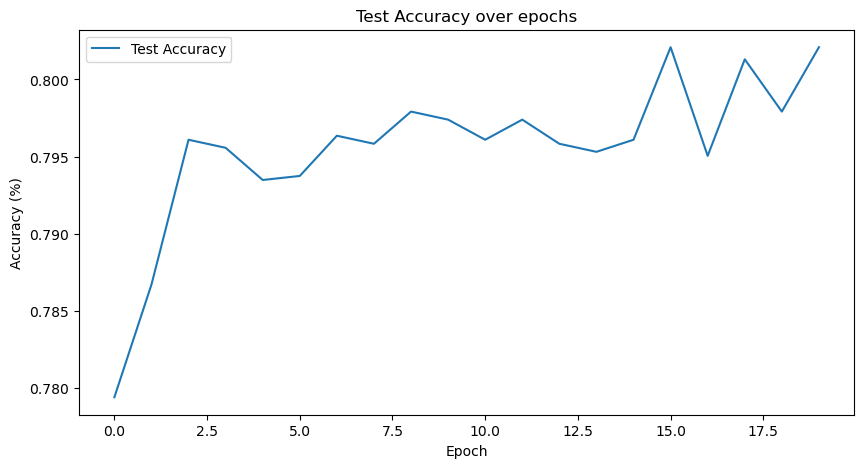

In [ ]:
# plot testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), acc_prog, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over epochs')
plt.legend()
plt.show()

## h1 vs h6

In [26]:
acc_h1 = test(model, test_loader_h1, device)
acc_h6 = test(model, test_loader_h6, device)

Test Accuracy: 0.8419
Test Accuracy: 0.7616
